In [24]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from keras.utils import to_categorical
from keras.optimizers import SGD
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
from keras.regularizers import l2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [7]:
pima_df = pd.read_csv('diabetes.csv')
pima_df = shuffle(pima_df)

In [8]:
labels = pima_df['Outcome']
features = pima_df.drop('Outcome', axis = 1)

In [9]:
features.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
92,7,81,78,40,48,46.7,0.261,42
756,7,137,90,41,0,32.0,0.391,39
425,4,184,78,39,277,37.0,0.264,31
545,8,186,90,35,225,34.5,0.423,37
734,2,105,75,0,0,23.3,0.560,53


In [10]:
scaler = MinMaxScaler(feature_range=(.05, .95))

continous = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

In [11]:
features[continous] = scaler.fit_transform(features[continous])

In [12]:
features = pd.get_dummies(features, columns = ['Pregnancies'])

In [13]:
features.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancies_0,Pregnancies_1,Pregnancies_2,...,Pregnancies_7,Pregnancies_8,Pregnancies_9,Pregnancies_10,Pregnancies_11,Pregnancies_12,Pregnancies_13,Pregnancies_14,Pregnancies_15,Pregnancies_17
92,0.416332,0.625410,0.413636,0.101064,0.676379,0.120325,0.365,0,0,0,...,1,0,0,0,0,0,0,0,0,0
756,0.669598,0.713934,0.422727,0.050000,0.479210,0.170282,0.320,0,0,0,...,1,0,0,0,0,0,0,0,0,0
425,0.882161,0.625410,0.404545,0.344681,0.546274,0.121477,0.200,0,0,0,...,0,0,0,0,0,0,0,0,0,0
545,0.891206,0.713934,0.368182,0.289362,0.512742,0.182579,0.290,0,0,0,...,0,1,0,0,0,0,0,0,0,0
734,0.524874,0.603279,0.050000,0.050000,0.362519,0.235226,0.530,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [14]:
split_num = 0.9
test_train_split = int(len(features)* split_num)
train_features, test_features = features[:test_train_split], features[test_train_split:]
train_labels, test_labels = labels[:test_train_split], labels[test_train_split:]

In [15]:
input_shape = features.shape[1]

In [415]:
model = Sequential()
model.add(Dense(32, input_shape = (input_shape,), activation = 'relu', activity_regularizer = l2(0.001)))#24
model.add(Dropout(.5))
model.add(Dense(64, activation = 'relu', activity_regularizer = l2(0.001)))#32
model.add(Dropout(.5))
model.add(Dense(1, activation = 'sigmoid'))

In [416]:
model.compile(loss = 'binary_crossentropy', optimizer = SGD(lr=0.001, momentum = 0.9), metrics = ['accuracy'])

In [417]:
checkpointer = ModelCheckpoint(filepath = 'pima_weights.hdf5', monitor = 'val_loss', save_best_only = True)

In [418]:
history = model.fit(train_features, train_labels, epochs = 5000, validation_split = 0.15, batch_size = 32, verbose = 0, callbacks = [checkpointer])

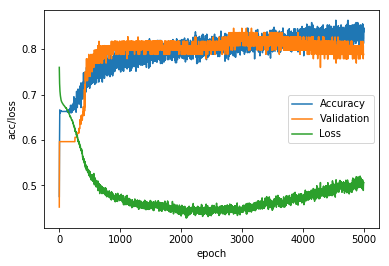

In [419]:
plt.plot(history.history['acc'], label = 'Accuracy')
plt.plot(history.history['val_acc'], label = 'Validation')
plt.plot(history.history['val_loss'], label = 'Loss')
plt.xlabel('epoch')
plt.ylabel('acc/loss')
plt.legend()
plt.show()

In [420]:
score = model.evaluate(test_features, test_labels)
score

77/77 [==============================] - 0s 97us/step


[0.66701691878306402, 0.72727272882089988]

In [421]:
model.load_weights('pima_weights.hdf5')

In [423]:
score = model.evaluate(test_features, test_labels)
score

77/77 [==============================] - 0s 89us/step


[0.56149897753418265, 0.76623376700785251]

In [452]:
evals = []
preds = model.predict(test_features)
for i in preds:
    if i > .5:
        evals.append(1)
    else:
        evals.append(0)

In [453]:
cm = confusion_matrix(test_labels, evals)
cm

array([[41,  8],
       [10, 18]])

In [455]:
precision_recall_fscore_support(test_labels, evals)

(array([ 0.80392157,  0.69230769]),
 array([ 0.83673469,  0.64285714]),
 array([ 0.82      ,  0.66666667]),
 array([49, 28]))

In [197]:
seed = 42
np.random.seed(seed)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
X = np.array(features)
y = np.array(labels)
for train, test in kfold.split(X, y):
    
    model = Sequential()
    model.add(Dense(24, input_shape = (input_shape,), activation = 'relu', activity_regularizer = l2(0.001)))#24
    model.add(Dropout(.4))
    model.add(Dense(32, activation = 'relu', activity_regularizer = l2(0.001)))#32
    model.add(Dropout(.4))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = SGD(lr=0.001, momentum = 0.9), metrics = ['accuracy'])
    model.fit(X[train], y[train], epochs = 5000, batch_size = 32, verbose = 0)

    scores = model.evaluate(X[test], y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

acc: 74.03%
acc: 75.32%
acc: 81.82%
acc: 77.92%
acc: 75.32%
acc: 74.03%
acc: 81.82%
acc: 74.03%
acc: 75.00%
acc: 80.26%
76.95% (+/- 3.07%)


In [ ]:
acc: 72.73%
acc: 74.03%
acc: 79.22%
acc: 75.32%
acc: 75.32%
acc: 76.62%
acc: 81.82%
acc: 72.73%
acc: 75.00%
acc: 85.53%
76.83% (+/- 3.95%)